# Simulação simples

In [6]:
import os
import sys

agent_list = os.listdir('agents')

print(agent_list)

sys.path.insert(0, 'agents')
sys.path.insert(0, 'environments')

['ps_agent_basic.py', 'ps_agent_flexible.py', '__pycache__']


In [7]:
import env_abp_target_finding as env

L = 100

Pe = 100
#Pe = (v*tao)/L #Péclet number

l = 1
#l = v/(D_theta*L) #persistence of directed motion in ABP phase

dt = 1

tao = int(dt/10e-4)
#tao = L*L/(4*D)

env = env.TaskEnvironment(L, Pe, l, tao, dt)

print(f'velocidade translacional: {env.v}')
print(f'coeficiente de desifusão translacional: {env.D}')
print(f'coeficiente de desifusão rotacional: {env.D_theta}')
print(f'typical time: {tao}')

param_dict = {
    5:{
        'gamma_damping' : 1e-7,
        'eta_glow_damping' : 1e-2
        },
    10:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    20:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    50:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-2
        },
    100:{
        'gamma_damping' : 1e-5,
        'eta_glow_damping' : 1e-2
        }
}

velocidade translacional: 10.0
coeficiente de desifusão translacional: 2.5
coeficiente de desifusão rotacional: 0.1
typical time: 1000


In [8]:
import ps_agent_basic as agent_class

#parameters for the agent - explanations can be found in the comments inside the agent file
gamma_damping = param_dict[Pe]['gamma_damping']
eta_glow_damping = param_dict[Pe]['eta_glow_damping']
policy_type = 'standard'#'softmax'
beta_softmax = 1
num_reflections =  0

agent = agent_class.BasicPSAgent(
    env.num_actions, env.num_percepts_list,
    gamma_damping, eta_glow_damping, 
    policy_type, beta_softmax,
    num_reflections
)

"""Initialise and run interaction"""

#set number of trials and maximum number of steps in each trial
num_trials = 500
max_steps_per_trial = 20*tao

for step in range(env.max_steps_per_trial):
    for state in range(env.num_states):
        percept = agent.percept_preprocess([state,step])
        if state == 0:
            agent.h_matrix[1, percept] = 1e-2
            agent.h_matrix[0, percept] = 1 - 1e-2

        elif state == 1:
            agent.h_matrix[1, percept] = 1e-3
            agent.h_matrix[0, percept] = 1 - 1e-3

agent.h0_matrix = agent.h_matrix

In [ ]:
#initialise a record of performance
posicoes = [] #guarda as posições
h_matrix = [] #guarda as probabilidades
statistics = [] #guarda os resultados do processo de aprendizado

reward = 0 #temporarily stores the reward for the most recent action

for i_trial in range(num_trials):
    
    reward_trial = 0 #additive counter of the total rewards earned during the current trial
    state_counter = 0 #conta qual estado ele está, considerando que a cada ação tomada vai para um novo estado
    reward_counter = 0 #conta quantos passos o agente demora para receber uma recompensa

    discretized_observation = env.reset() #reinicia a posição do target
    agent.g_matrix = np.zeros((agent.num_actions, agent.num_percepts), dtype=np.float64) #reinicia a matriz de movimentos
    
    for t in range(max_steps_per_trial):
        action = agent.deliberate_and_learn(discretized_observation, reward)

        if action:
            state_counter += 1 # se tomou uma ação de mudar de estado, atualiza o contador de estado

        discretized_observation_aux = discretized_observation #salva a observação inicial

        target_pos = env.target_position
        discretized_observation, reward, done = env.move(action) #atualiza o ambiente

        reward_trial += reward #conta a recompensa
        reward_counter += 1 #atualiza quantos passos demorou para receber uma recompensa
        
        if (i_trial == 0) | (i_trial == num_trials - 1):
            posicoes.append([
                    env.r[0], env.r[1], env.dr, env.dr_theta, i_trial, t, 
                    target_pos[0], target_pos[1], 
                    action, discretized_observation_aux, reward, state_counter, 
                    env.distance, reward_counter, reward_trial
                ])
        
        if reward == 1:
            statistics.append([i_trial, t, reward_counter, state_counter, reward, reward_trial])
            reward_counter = 0 #se recebeu recompensa, zera o contador
            state_counter = 0
            
    h_matrix.append([i_trial, h_matrix])
    print(i_trial, reward_trial, t/reward_trial/tao)

In [62]:
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [79]:
db_stats = pd.DataFrame(statistics, columns = ['i_trial', 't', 'reward_counter', 'state_counter', 'reward', 'reward_trial'])
db_stats = (max_steps_per_trial/db_stats.groupby('i_trial')['reward_trial'].max()/tao).reset_index()
db_stats

,i_trial,reward_trial
0,0,4.000000
1,1,1.538462
2,2,1.666667
3,3,1.428571
4,4,0.952381
...,...,...
284,284,0.740741
285,285,0.625000
286,286,0.487805
287,287,0.740741


In [80]:
alt.Chart(db_stats).mark_line().encode(
    x = 'i_trial',
    y = 'reward_trial'
)

alt.Chart(...)

In [81]:
db = pd.DataFrame(
    posicoes, 
    columns = ['x','y','dr','dr_theta','trial','step',
               'x_target','y_target','action',
               'obs','reward','state_counter',
               'distance','reward_counter','reward_trial'])

db[['state','counter']] = db['obs'].apply(pd.Series)

db

,x,y,dr,dr_theta,trial,step,x_target,y_target,action,obs,reward,state_counter,distance,reward_counter,reward_trial,state,counter
0,96.226741,95.745893,"[-3.7732589861509793, -4.254106635458766]","[-0.0, 0.0]",0,0,63.697449,53.076523,0,"[0, 0]",0,0,53.654729,1,0,0,0
1,95.048191,90.834959,"[-1.1785496341920638, -4.910934465021595]","[-0.0, 0.0]",0,1,63.697449,53.076523,0,"[0, 1]",0,0,49.077169,2,0,0,1
2,97.623649,94.721771,"[2.5754579036897183, 3.8868116307461302]","[-0.0, 0.0]",0,2,63.697449,53.076523,0,"[0, 2]",0,0,53.715116,3,0,0,2
3,98.269079,93.981523,"[0.6454298994059975, -0.7402476154245249]","[-0.0, 0.0]",0,3,63.697449,53.076523,0,"[0, 3]",0,0,53.557601,4,0,0,3
4,98.882038,95.593920,"[0.6129586547559112, 1.6123971854503985]","[-0.0, 0.0]",0,4,63.697449,53.076523,0,"[0, 4]",0,0,55.187719,5,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,50.269453,74.488488,"[0.2874787706500834, 0.4497768493705958]","[-6.3775379740189395, 7.702402832230108]",0,19995,56.507347,22.465432,0,"[1, 65]",0,37,52.395703,3826,5,1,65
19996,47.598357,84.500884,"[3.0214318441645354, 1.790770611373686]","[-5.692527423425715, 8.221625844901128]",0,19996,56.507347,22.465432,0,"[1, 66]",0,37,62.671903,3827,5,1,66
19997,38.655443,89.179917,"[-4.588612973512098, -4.323192772176264]","[-4.354300915178645, 9.002225477073678]",0,19997,56.507347,22.465432,0,"[1, 67]",0,37,69.061661,3828,5,1,67
19998,34.566568,0.743800,"[0.45136248072806795, 2.6539869151591646]","[-4.540237914864948, 8.909895604125943]",0,19998,56.507347,22.465432,0,"[1, 68]",0,37,30.874376,3829,5,1,68


In [89]:
alt.Chart(db.query('trial == 0').query('reward_trial == 0')).mark_circle().encode(
    x = 'x',
    y = 'y',
    order = 'step',
    color = 'state:N'
)

alt.Chart(...)

MovieWriter ffmpeg unavailable; using Pillow instead.


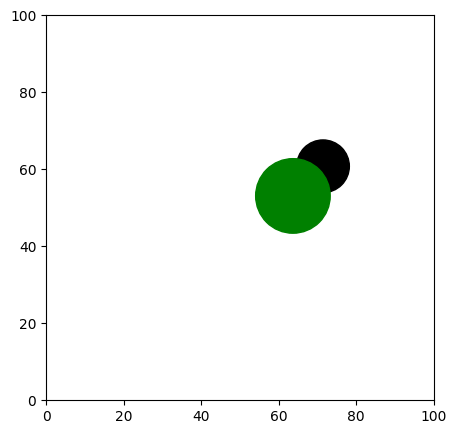

In [90]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera

trial = 0
reward_trial = 0
target_x = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['x_target'].values[-1]
target_y = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['y_target'].values[-1]


x_data = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['x'].values
y_data = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['y'].values
states = db.query(f'trial == {trial}').query(f'reward_trial == {reward_trial}')['state'].map({0:'black',1:'red'}).values
color = states

fig = plt.figure(figsize=[5, 5])
camera = Camera(fig)

# Raio das partículas de acordo com o tamanho da figura
points_whole_ax = 5 * 0.8 * 72    # 1 point = dpi / 72 pixels
radius = 0.05*L
points_radius = 2 * radius / 1.0 * points_whole_ax

ax = plt.axes(xlim=(0, L), ylim=(0, L))

for i in range(len(x_data)):
    plt.scatter(
        *np.array([[x_data[i],target_x], [y_data[i],target_y]]), 
        c=np.array([color[i],'green']), 
        s=[points_radius/2,points_radius]
    )
    camera.snap()

anim = camera.animate(blit=True)
anim.save('scatter.gif', fps=10, dpi=200)